In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from __future__ import division

import numpy as np
import glob, os, json
import matplotlib.pyplot as plt
import scipy.linalg as sl

import libstempo as libs
import libstempo.plot as libsplt

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [4]:
topdir = os.getcwd()
#Where the original data is
datadir = topdir + '/mdc2/group1/dataset_1b'
#Where the json noise file is
noisefile = topdir + '/mdc2/group1/challenge1_psr_noise.json'
#Where the refit par files are
pardir = topdir + '/dataset_1b/dataset_1b_correctedpars/'
#Where the chains should be saved to
#NEED TO CHANGE OUTDIR FILE ON DIFFERENT RUNS (ie open1 -> open2)
chaindir = topdir + '/dataset_1b/chains/'
outdir = topdir + '/dataset_1b/full_run_1'
#Where we save figures n stuff
figdir = topdir + '/dataset_1b/Cornerplts/'
#Where we saved the new json file
noisedir = topdir + '/dataset_1b/'
#The new json file we made
updatednoisefile = noisedir + 'fit_psr_noise.json'


parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

In [4]:
def Refit_pars(origdir,newdir):
    orig_parfiles = sorted(glob.glob(origdir + '/*.par'))
    orig_timfiles = sorted(glob.glob(origdir + '/*.tim'))
    #Load all of the Pulsars into libstempo
    orig_libs_psrs = []
    for p, t in zip(orig_parfiles, orig_timfiles):
        orig_libs_psr = libs.tempopulsar(p, t)
        orig_libs_psrs.append(orig_libs_psr)

    #Fit the par files again
    #Save them to new directory (Overwrites ones currently used in savedir)
    #NOT WORKING ANYMORE
    for orig_libs_psr in orig_libs_psrs:
        orig_libs_psr['DM'].fit = False
        orig_libs_psr['DM1'].fit = False
        orig_libs_psr['DM2'].fit = False
        orig_libs_psr.fit(iters=10)
        orig_libs_psr.savepar(newdir + orig_libs_psr.name + '.par')
        orig_libs_psr.savetim(newdir + orig_libs_psr.name + '.tim')

In [5]:
#Load all Pulsars into enterprise
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)
print(len(psrs))

33


In [19]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

In [21]:
##### parameters and priors #####

# Uniform prior on EFAC and EQUAD
efac = parameter.Normal(1.0,0.1)
log10_equad = parameter.Uniform(-8.5,5.0)

# red noise parameters
# Uniform in log10 Amplitude and in spectral index
red_noise_log10_A = parameter.Uniform(-18,-12)
red_noise_gamma = parameter.Uniform(0,7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
gwb_log10_A = parameter.LinearExp(-18,-12)('zgwb_log10_A')
gwb_gamma = parameter.Constant(13/3)('zgwb_gamma')

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad = log10_equad)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=red_noise_log10_A, gamma=red_noise_gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A = gwb_log10_A, gamma = gwb_gamma)
#gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)

# We pass this signal the power-law spectrum as well as the standard
# Hellings and Downs ORF
orf = utils.hd_orf()
gwb = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd = True)

# full model is sum of components
model = ef + eq + rn + tm  + gwb

# initialize PTA
pta = signal_base.PTA([model(psr) for psr in psrs])

In [22]:
#Get White Noise parameters from json file
with open(updatednoisefile, 'r') as nf:
        noise_dict = json.load(nf)
        nf.close()
#Unpacking dictionaries in json file to get at noise values
params = {}
for psr in psrs:
    params.update(noise_dict[psr.name])

#pta.set_default_params(params)

In [23]:
#Pick random initial sampling
xs = {par.name: par.sample() for par in pta.params}

# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups
ndim = len(xs)
groups  = [range(0, ndim)]
groups.extend(map(list, zip(range(0,ndim,2), range(1,ndim,2))))
groups.extend([[36]])

# intialize sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, outDir = outdir)

In [25]:
# sampler for N steps
N = 10000
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 10.00 percent in 165.315500 s Acceptance rate = 0.871

/home/andrew/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:66: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 40.00 percent in 658.133311 s Acceptance rate = 0.820533

KeyboardInterrupt: 

In [14]:
chain = np.loadtxt(outdir + '/chain_1.txt')
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])
#corner.corner(chain[burn:,:-4], 30, labels=pars);
#plt.show()

/home/andrew/anaconda3/envs/enterprise/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


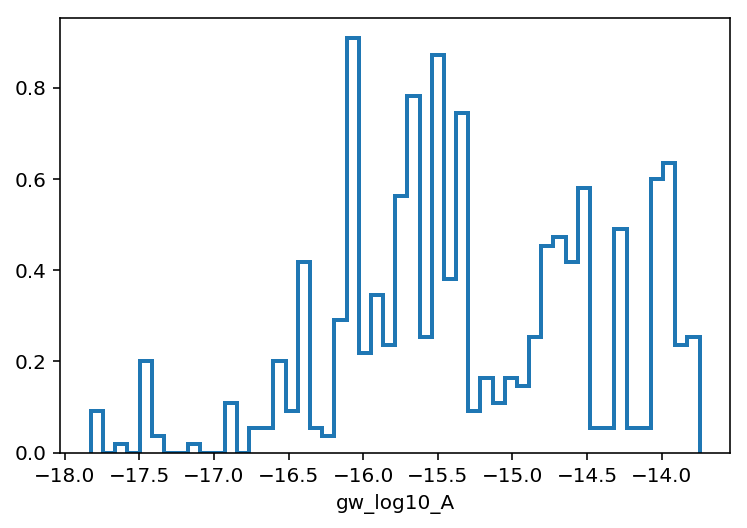

In [26]:
plt.hist(chain[burn:,-5], 50, normed=True, histtype='step', lw=2);
plt.xlabel(pars[-1]);